# Northwind Data Insights

The company Northwind has asked me to analyze the data in their local database to provide insights on potential future strategies. While digging into the data, I came up with four question to investigate and test to determine whether there was significance within highlights of the data. I focused on 3 key areas within the business:
1. The significance of discounts on quantity of products purchased.
2. The significance of product categories on revenue.
3. The significance of revenue produced by specific employees.

Below is the database schema for Northwind from which I will be pulling the data for analysis.

<img src='Northwind_ERD.png'>

The first thing i wanted to do was import all necessary python libraries to complete the analysis.

In [1]:
import sqlalchemy #used to communicate tasks to the SQL database
from sqlalchemy import create_engine, inspect 
import pandas as pd #used to convert the data needed into a pandas database for further analysis
import matplotlib.pyplot as plt #to create the data visualization
import numpy as np
from scipy import stats # used to run T-Tests for hypothesis testing
import statsmodels.stats.multicomp as stat # used to run the tukey analysis for hypothesis testing


To bring the SQL database in to run the analysis, I will need to create an engine that responds to my SQL queries.

In [2]:
engine = create_engine('sqlite:///northwind_small.sqlite',echo=True)
inspector = inspect(engine)

2019-01-24 11:37:15,622 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-24 11:37:15,633 INFO sqlalchemy.engine.base.Engine ()
2019-01-24 11:37:15,634 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-24 11:37:15,635 INFO sqlalchemy.engine.base.Engine ()


Now that the database can be access via an SQL query and python code, I will start investigating my questions to come up with valuable insights.

## Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

I created the following one tail null hypothesis and alternative hypothesis to answer this question:

**H0: The mean quantity of products sold with a discount = the mean quantity of products sold without a discount **

**HA: The mean quantity of products sold with a discount > the mean quantity of products sold without a discount **



Looking at the schema above, I believe all the information needed to answer this question can be found in the Order Details table. Below is the code used to create a Pandas DataFrame for this table.

In [3]:
inspector.get_table_names() #looks at the schema's names for each data table

2019-01-24 11:37:16,570 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-24 11:37:16,571 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:
df = pd.read_sql_query("select * from [OrderDetail]",engine) #creates the dataframe from the Order Detail data table in the SQL database
df.head()

2019-01-24 11:37:16,974 INFO sqlalchemy.engine.base.Engine select * from [OrderDetail]
2019-01-24 11:37:16,975 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Before starting the hypothesis testing, I did a quick check for any missing values or outliers I should review before beginning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [6]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


I am comfortable with the data and will begin investigating the question. I first wanted to get a sense of total quantity sold at each discount level to see if there is initial evidence that our question could be true. For that I created the histograms for each discount level as well as pulled the mean quantity sold value to compare.

In [7]:
df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [1]:
vals = [0, 10, 15, 20, 25] #creating our keys and values to turn our discounts into a dictionary format
keys = ['d_{}'.format(val) for val in vals]

In [9]:
discounts = dict() #creating a dictionary of discount keys to their quantity values
for key, val in zip(keys, vals):
    discounts[key] = None
    ddf = df.Quantity[df.Discount==0.01*val]
    discounts[key] = ddf
discounts['d_all'] = df.Quantity[df.Discount > 0.00] # I also added a total quantity group with all discounts applied.
discounts['d_under_10'] = df.Quantity[(df.Discount> 0.00) & (df.Discount < 0.10)] # I decided to combine the discounts less than 10% into on group

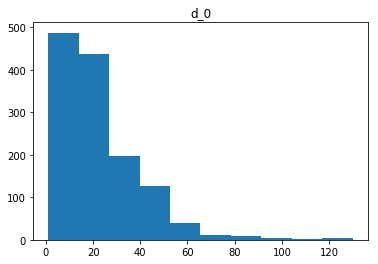

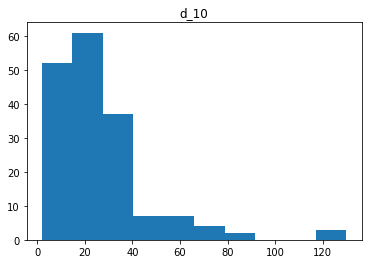

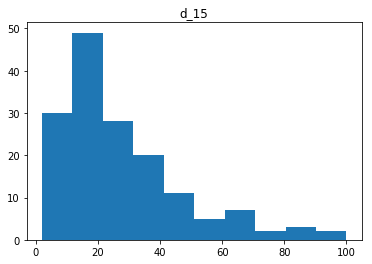

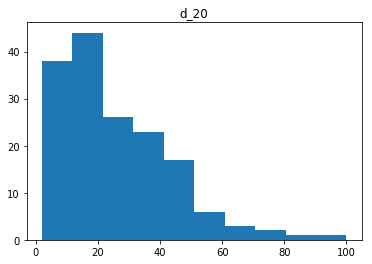

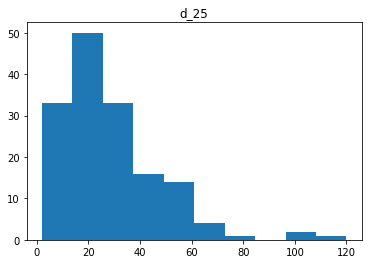

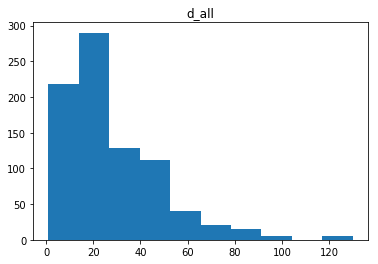

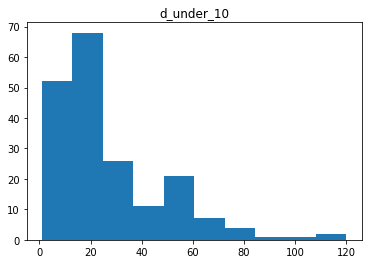

In [10]:
for discount, q in discounts.items(): #histogram for each group
    plt.hist(q)
    plt.title(discount)
    plt.show()

In [11]:
for i in discounts.keys(): # provides the mean score of quantity sold per product for each discount level
    print(i,'quantity mean:',discounts[i].mean())

d_0 quantity mean: 21.715261958997722
d_10 quantity mean: 25.23699421965318
d_15 quantity mean: 28.38216560509554
d_20 quantity mean: 27.024844720496894
d_25 quantity mean: 28.24025974025974
d_all quantity mean: 27.10978520286396
d_under_10 quantity mean: 26.922279792746114


As you can see above, the greatest frequency of quantities increases as the discounts increase, giving us a good sense that quantity purchase is influenced by discounts. Also, each discount level's mean quantity sold is greater than the mean quantity sold for products at a zero discount. I will move forward with hypothesis testing.

For my hypothesis testing to see if there is any significance with this influence, I decided to run a Tukey test, which compares every combination of comparison in the groups provided to see where significance lies. I will use an alpha score of 0.05, meaning if I get a P-value less than that, I can reject our null hypothesis for that discount group and state that there is statistical significance with the use of discounts. The comparisons I am most interested in seeing are:

1. Zero discounts versus all discounts
2. Zero discounts versus each level of discount

The below code is used to run our Tukey test:


In [12]:
v = np.concatenate(list(discounts.values())) # this code creates our list of values and labels that the statsmodel tukey code can understand
l = []
for i in discounts.keys():
    l.append([i] * len(discounts[i]))
label = np.concatenate(l)


In [13]:
print(stat.pairwise_tukeyhsd(v, label, alpha=0.05)) # runs the tukey analysis

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1   group2   meandiff  lower   upper  reject
-------------------------------------------------
 d_0      d_10     3.5217  -1.1084  8.1518 False 
 d_0      d_15     6.6669   1.8328  11.501  True 
 d_0      d_20     5.3096   0.5294 10.0898  True 
 d_0      d_25     6.525    1.649   11.401  True 
 d_0     d_all     5.3945   2.8645  7.9245  True 
 d_0   d_under_10  5.207    0.7941   9.62   True 
 d_10     d_15     3.1452  -3.1658  9.4561 False 
 d_10     d_20     1.7879  -4.4819  8.0576 False 
 d_10     d_25     3.0033  -3.3399  9.3464 False 
 d_10    d_all     1.8728  -2.9085  6.6541 False 
 d_10  d_under_10  1.6853  -4.3092  7.6798 False 
 d_15     d_20    -1.3573  -7.7792  5.0646 False 
 d_15     d_25    -0.1419  -6.6355  6.3516 False 
 d_15    d_all    -1.2724  -6.2515  3.7067 False 
 d_15  d_under_10 -1.4599  -7.6133  4.6936 False 
 d_20     d_25     1.2154  -5.2381  7.6689 False 
 d_20    d_all     0.0849  -4.8418  5.0117 False 

As we can see above, we can reject the null hypothesis when comparing no discounts to any level of discount, except for a discount of 10%. I also decide to run a Cohen D test to see the effect size of these significance.

In [14]:
def Cohen_d(group1, group2): #function that takes two groups of data and determines the effect size change from one to another

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

#Small effect = 0.2
#Medium Effect = 0.5
#Large Effect = 0.8

for i in discounts.keys(): # use this function to compare all discount levels to zero discounts
    print(i,'Effect Size:',Cohen_d(discounts[i],discounts['d_0']))

d_0 Effect Size: 0.0
d_10 Effect Size: 0.19594203057834086
d_15 Effect Size: 0.3724041317472808
d_20 Effect Size: 0.3007122542913553
d_25 Effect Size: 0.36659255652674416
d_all Effect Size: 0.2862724481729282
d_under_10 Effect Size: 0.28613491894928983


The effect sizes for all comparisons are shown to be between 0.2 and 0.4, meaning they are small effects.

So as we can see from the Tukey test, we were able to reject the null hypothesis and determine there is a statistical significance to using discounts on products to influence the quantity of products purchased from customers. There was statistical significance at all levels of discounts except for 10%. Although we could not reject the null hypothesis for 10% discount, our data did show a larger mean quantity purchased at this level. This means that although there seems to be evidence of increased quantity purchased at 10% discount, the increase is not within our threshold of 0.05 to state that the probability of this happening is too low. Our Cohen D test showed that the effects of the discounts on quantity purchase is small.

For the business, what this means is that if Northwind is looking to increase their quantity purchased from their customers, determining a price strategy that includes a discount is an effective way to accomplish this. 15% and 25% seem to be the most effective discounts to use to increase quantity purchased.

## Do discounts for different product categories have a statistically significant effect on the number of products customers order from that product category?

Below is the one tail hypothesis test I will conduct to answer this questions:

**H0: The mean quantity of products sold for each product category with a discount = the mean quantity of products sold without a discount **

**HA: The mean quantity of products sold for each product category with a discount > the mean quantity of products sold without a discount **

To answer this question, I will need to combine a few of the data tables from the database. Below is the SQL queries I ran, as well as the pandas merges to combine the dataframes that includes order details, product information, and product category information to run the analysis.

In [15]:
df1 = pd.read_sql_query("select * from [OrderDetail] left join [Order] on [Order].Id = OrderDetail.OrderId",engine) # creates a dataframe combining the Order Detail and Order data tables from the database
df2 = pd.read_sql_query("select * from [Product] inner join Category on Category.Id = Product.CategoryId ",engine) # creates a dataframe combining the Product data table with the category data table
column_names = df2.columns.values
column_names[10] = 'Id_z' #in order to merge these dataframes, i need to remove a copy of the 'Id' column
df2.columns = column_names
merg_df = pd.merge(df1,df2,how='left',left_on='ProductId',right_on='Id') #merging the dataframes into one
merg_df = merg_df.drop(labels='Id_x',axis=1)

2019-01-24 11:37:33,363 INFO sqlalchemy.engine.base.Engine select * from [OrderDetail] left join [Order] on [Order].Id = OrderDetail.OrderId
2019-01-24 11:37:33,365 INFO sqlalchemy.engine.base.Engine ()
2019-01-24 11:37:33,393 INFO sqlalchemy.engine.base.Engine select * from [Product] inner join Category on Category.Id = Product.CategoryId 
2019-01-24 11:37:33,394 INFO sqlalchemy.engine.base.Engine ()


In [16]:
merg_df.head()

,OrderId,ProductId,UnitPrice_x,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,...,CategoryId,QuantityPerUnit,UnitPrice_y,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_z,CategoryName,Description
0,10248,11,14.0,12,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,...,4,1 kg pkg.,21.00,22,30,30,0,4,Dairy Products,Cheeses
1,10248,42,9.8,10,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,...,5,32 - 1 kg pkgs.,14.00,26,0,0,1,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
2,10248,72,34.8,5,0.0,VINET,5,2012-07-04,2012-08-01,2012-07-16,...,4,24 - 200 g pkgs.,34.80,14,0,0,0,4,Dairy Products,Cheeses
3,10249,14,18.6,9,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,...,7,40 - 100 g pkgs.,23.25,35,0,0,0,7,Produce,Dried fruit and bean curd
4,10249,51,42.4,40,0.0,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,...,7,50 - 300 g pkgs.,53.00,20,0,10,0,7,Produce,Dried fruit and bean curd


In [17]:
merg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 31 columns):
OrderId            2155 non-null int64
ProductId          2155 non-null int64
UnitPrice_x        2155 non-null float64
Quantity           2155 non-null int64
Discount           2155 non-null float64
CustomerId         2155 non-null object
EmployeeId         2155 non-null int64
OrderDate          2155 non-null object
RequiredDate       2155 non-null object
ShippedDate        2082 non-null object
ShipVia            2155 non-null int64
Freight            2155 non-null float64
ShipName           2155 non-null object
ShipAddress        2155 non-null object
ShipCity           2155 non-null object
ShipRegion         2155 non-null object
ShipPostalCode     2100 non-null object
ShipCountry        2155 non-null object
Id_y               2155 non-null int64
ProductName        2155 non-null object
SupplierId         2155 non-null int64
CategoryId         2155 non-null int64
QuantityPerUnit   

For this testing, I decided to do the similar procedure as was done to answer the first question, but I added another layer of filtering to include the category of the products sold. To save space in this jupyter notebook, I ran the analysis for one of the categories, and then would substitute the category each time, instead of running all categories at once. The "catkey" variable in the below code is where the product category is entered, followed by rerunning the code after its to get the results.

In [18]:
merg_df.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [19]:
list(merg_df.CategoryName.unique())

['Dairy Products',
 'Grains/Cereals',
 'Produce',
 'Seafood',
 'Condiments',
 'Confections',
 'Beverages',
 'Meat/Poultry']

In [20]:
catkey = 'Meat/Poultry' # **CHANGE THIS EVERY RUN TO A DIFFERENT CATEGORY TO RUN THE HYPOTHESIS TEST**
discounts = dict()
for key, val in zip(keys, vals):
    discounts[key] = None
    ddf = merg_df.Quantity[(merg_df.Discount==0.01*val)&(merg_df.CategoryName == catkey)]
    discounts[key] = ddf
discounts['d_all'] = merg_df.Quantity[(df.Discount > 0.00) &(merg_df.CategoryName == catkey)]
discounts['d_under_10'] = merg_df.Quantity[(merg_df.Discount> 0.00) & (merg_df.Discount < 0.10) & (merg_df.CategoryName == catkey)]


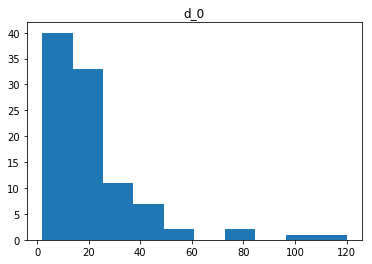

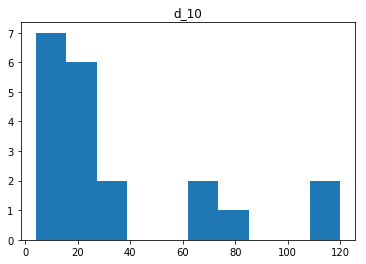

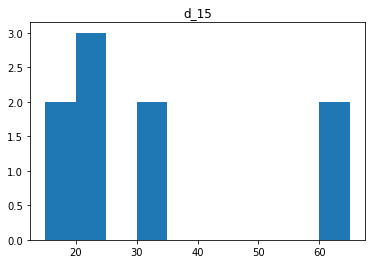

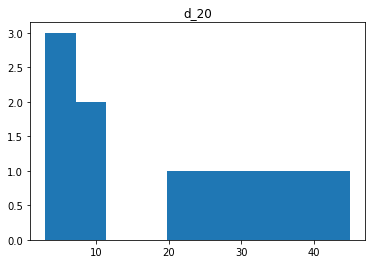

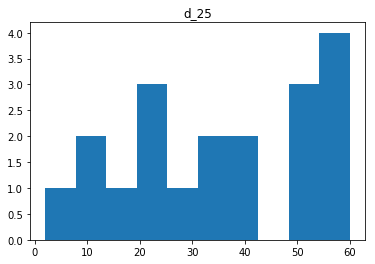

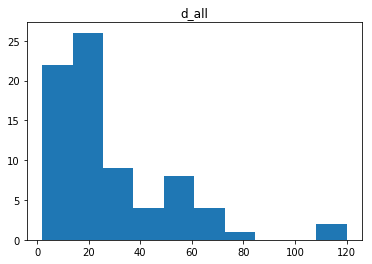

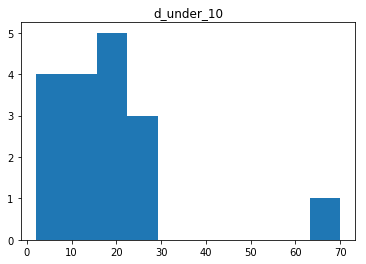

In [21]:
for discount, q in discounts.items():
    plt.hist(q)
    plt.title(discount)
    plt.show()

In [22]:
for i in discounts.keys():
    print(i,'quantity mean:',discounts[i].mean())

d_0 quantity mean: 20.721649484536083
d_10 quantity mean: 35.2
d_15 quantity mean: 31.444444444444443
d_20 quantity mean: 21.0
d_25 quantity mean: 35.1578947368421
d_all quantity mean: 28.80263157894737
d_under_10 quantity mean: 17.823529411764707


By running the histograms and seeing the mean quantity purchased for each category, I continued to see evidence that all the categories showed increased quantity purchased as discounts were included. So I ran the Tukey test again with an alpha threshold of 0.05 to see at each level of discount whether there was significance in this increase of quantity purchased.

In [23]:
v = np.concatenate(list(discounts.values()))
l = []
for i in discounts.keys():
    l.append([i] * len(discounts[i]))
label = np.concatenate(l)


In [24]:
print(stat.pairwise_tukeyhsd(v, label, alpha=0.05))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1   group2   meandiff  lower    upper  reject
--------------------------------------------------
 d_0      d_10    14.4784  -1.9764  30.9331 False 
 d_0      d_15    10.7228  -12.625  34.0706 False 
 d_0      d_20     0.2784  -21.0388 21.5955 False 
 d_0      d_25    14.4362  -2.3737  31.2462 False 
 d_0     d_all     8.081   -2.1833  18.3453 False 
 d_0   d_under_10 -2.8981  -20.5155 14.7193 False 
 d_10     d_15    -3.7556   -30.65  23.1389 False 
 d_10     d_20     -14.2   -39.3518 10.9518 False 
 d_10     d_25    -0.0421  -21.5076 21.4234 False 
 d_10    d_all    -6.3974  -23.2363 10.4415 False 
 d_10  d_under_10 -17.3765  -39.48   4.727  False 
 d_15     d_20    -10.4444 -40.5604 19.6715 False 
 d_15     d_25     3.7135  -23.3997 30.8266 False 
 d_15    d_all    -2.6418  -26.2619 20.9783 False 
 d_15  d_under_10 -13.6209 -41.242  14.0002 False 
 d_20     d_25    14.1579  -11.2277 39.5435 False 
 d_20    d_all     7.8026  -13.

After running through all the Tukey testing for each product category to determine significance, all the tests failed to reject our null hypothesis, meaning that I could not find any significance in a particular product category being influenced by discounts towards increase quanitities of purchase.

For the business, what this means is that product category does not have an influence in how well discounts influence the quantity of products purchase, and that referring to the first question will help drive discount strategies for increase quantity purchase.

## Is there statistical significance in the category of product based on the revenue they produce?

Below is the one tail hypothesis test I will conduct to answer this questions:

*H0: The mean revenue of products sold at specific product categories = the mean revenue of all products sold *

*HA: The mean revenue of products sold at specific product categories >  the mean revenue of all products sold *

In [25]:
merg_df.columns

Index(['OrderId', 'ProductId', 'UnitPrice_x', 'Quantity', 'Discount',
       'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate',
       'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity',
       'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'Id_y', 'ProductName',
       'SupplierId', 'CategoryId', 'QuantityPerUnit', 'UnitPrice_y',
       'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued', 'Id_z',
       'CategoryName', 'Description'],
      dtype='object')

I was able to use our merged dataframe from the previous analysis to answer the question. I created the following 'Revenue' column in our dataframe which created our revenue received from each product sold

In [26]:
merg_df['Revenue'] = merg_df['UnitPrice_x'] * merg_df['Quantity'] * (1-merg_df['Discount']) #code to add a Revenue column

Text(0, 0.5, 'Total Revenue')

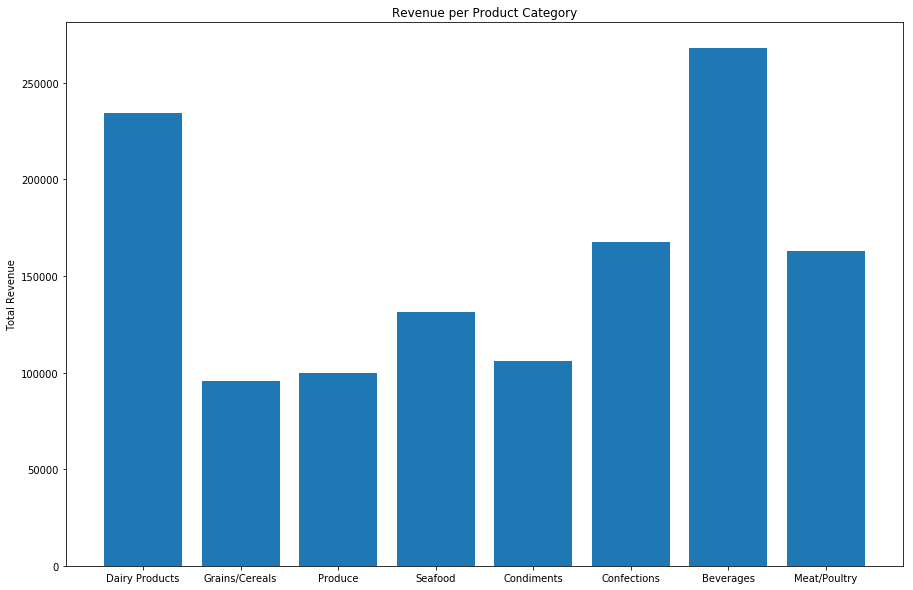

In [27]:
rev_dict = dict() #creates a dictionary of our revenue to category names
keys = list(merg_df.CategoryName.unique())
for i in keys:
    rev_dict[i] = None
    valu = merg_df.Revenue[merg_df.CategoryName == i].sum()
    rev_dict[i] = valu
   
plt.figure(figsize=(15,10)) #bar chart to look at total revenue per category
plt.bar(rev_dict.keys(),rev_dict.values())
plt.title('Revenue per Product Category')
plt.ylabel('Total Revenue')

In [28]:
stud_val = list(merg_df.CategoryName.unique()) #provides a dictionary of categories and all products sold per revenue generated
revs_dict = dict()
for key in stud_val:
    revs_dict[key]=None
    revs_dict[key] = merg_df.Revenue[merg_df.CategoryName == key]
revs_dict['All'] = merg_df.Revenue


In [29]:
for keys in revs_dict.keys():
    print(keys,'revenue mean:',revs_dict[keys].mean())

Dairy Products revenue mean: 640.7302868852458
Grains/Cereals revenue mean: 488.4927933673469
Produce revenue mean: 735.1807352941175
Seafood revenue mean: 397.76284090909087
Condiments revenue mean: 490.9587268518518
Confections revenue mean: 501.06953592814364
Beverages revenue mean: 663.0400495049505
Meat/Poultry revenue mean: 942.3257774566473
All revenue mean: 587.374960324826


Based on the above bar chart showing total revenue collected by product category, and the mean revenue per product per category, you can see that not all product categories sell the same. We will follow this insight up by running a two sample T-test on each category compared to the total mean revenue generated to see if any category has a statistical significance in their revenue generated.

In [30]:
for keys in revs_dict.keys(): #two sample T-test comparing each product category's average revenue to the total average revenue
    print(keys,':',stats.ttest_ind(revs_dict[keys], revs_dict['All']))

Dairy Products : Ttest_indResult(statistic=1.0102913512199867, pvalue=0.3124527555341981)
Grains/Cereals : Ttest_indResult(statistic=-1.4089582081468492, pvalue=0.15897988296284438)
Produce : Ttest_indResult(statistic=1.7440240345560045, pvalue=0.08128913390873187)
Seafood : Ttest_indResult(statistic=-3.50192473110934, pvalue=0.0004700629525197672)
Condiments : Ttest_indResult(statistic=-1.4454221885519987, pvalue=0.14847160031322224)
Confections : Ttest_indResult(statistic=-1.5782139079063604, pvalue=0.11464365138893773)
Beverages : Ttest_indResult(statistic=1.2537035880483638, pvalue=0.21006437402488798)
Meat/Poultry : Ttest_indResult(statistic=4.504742567566793, pvalue=6.973989269882504e-06)
All : Ttest_indResult(statistic=0.0, pvalue=1.0)


In [31]:
for keys in revs_dict.keys(): #Cohen D test to test effect size of significance
    print(keys,'Effect Size:',Cohen_d(revs_dict[keys],revs_dict['All']))

Dairy Products Effect Size: 0.057121709308067085
Grains/Cereals Effect Size: -0.10513078636635244
Produce Effect Size: 0.15420683945099964
Seafood Effect Size: -0.207036738617528
Condiments Effect Size: -0.10317447421688597
Confections Effect Size: -0.09281594757497037
Beverages Effect Size: 0.06795579524561468
Meat/Poultry Effect Size: 0.35592251164345506
All Effect Size: 0.0


Based on our two sample t test for each product category, we found that by using an alpha level of 0.05, that Seafood and Meat/Poultry both are statistically significant in their difference between the their revenue generated and the mean revenue generated amongst all products. Their effect size is considered small, but based on their P-Value and mean revenue generated, we can conclude the following for the business:

1. Seafood's average revenue generated per product is lower than the mean of all products, meaning we need to investigate more into the selling strategy in order to increase sales.
2. Meat/Poultry's average revenue generated per product is higher than the mean of all products, meaning that we could potentially develop new sellings strategies for other products that reflect what selling strategies we have been using for Meat/Poultry.

# Is there statistical significance in the different total revenue generated by each sales representative?

Below is the one tail hypothesis test I will conduct to answer this questions:

*H0: The mean revenue of products for each sales representative = the mean revenue of products sold for all sales representatives *

*HA: The mean revenue of products for each sales representative > the mean revenue of products sold for all sales representatives *


I was able to use our DataFrame that combined the 'Order' and 'Order Details' data tables into one dataset. This combined table provides an employee indicator. I will need to add a 'Revenue' column similar to what I created above.

In [32]:
df1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [33]:
df1['Revenue'] = df1.UnitPrice * df1.Quantity * (1-df1.Discount) #creating the Revenue column

In [34]:
df1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,...,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Revenue
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,...,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,168.0
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,...,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,98.0
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,...,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,174.0
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,...,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,167.4
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,...,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1696.0


Text(0, 0.5, 'Total Revenue Generated')

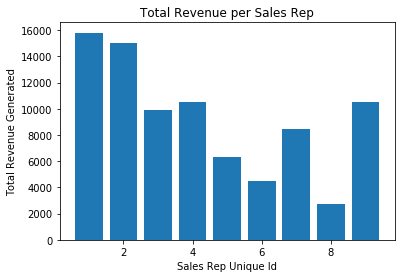

In [35]:
plt.bar(df1.EmployeeId,df1.Revenue) #bar chart comparing total revenue by employee
plt.title('Total Revenue per Sales Rep')
plt.xlabel('Sales Rep Unique Id')
plt.ylabel('Total Revenue Generated')

In [36]:
emp_key = list(df1.EmployeeId.unique()) #similar to the above insights, i create a dictionary with the employee as the key and all their revenues as values
emp_dict = dict()
for key in emp_key:
    emp_dict[key] = None
    va = df1.Revenue[df1.EmployeeId==key]
    emp_dict[key] = va
emp_dict['All']=df1.Revenue

In [37]:
for key in emp_dict.keys():
    print(key,'Mean Revenue:',emp_dict[key].mean())

5 Mean Revenue: 587.9682264957265
6 Mean Revenue: 439.95910416666675
4 Mean Revenue: 554.5020142857143
3 Mean Revenue: 631.8157102803739
9 Mean Revenue: 722.5052943925234
1 Mean Revenue: 556.833636231884
8 Mean Revenue: 487.9318365384616
2 Mean Revenue: 691.0280290456432
7 Mean Revenue: 707.7740625
All Mean Revenue: 587.374960324826


As we can see from the above bar chart showing revenue generated per sales representative, and the mean revenue generated that there is a difference between some representatives and the total mean revenue generated. I will be running a two sample t test comparing each rep to the total rep score to see if any of these differences is significant.

In [38]:
for keys in emp_dict.keys():
    print(keys,':',stats.ttest_ind(emp_dict[keys], emp_dict['All']))

5 : Ttest_indResult(statistic=0.0064877833372402015, pvalue=0.9948241042354075)
6 : Ttest_indResult(statistic=-1.948142856060304, pvalue=0.051518257670220786)
4 : Ttest_indResult(statistic=-0.6496215214175025, pvalue=0.5159947154419077)
3 : Ttest_indResult(statistic=0.7615617721896389, pvalue=0.4463941850901262)
9 : Ttest_indResult(statistic=1.3804481239369464, pvalue=0.16758522714021196)
1 : Ttest_indResult(statistic=-0.5372945809537059, pvalue=0.5911120035649866)
8 : Ttest_indResult(statistic=-1.6301047353075346, pvalue=0.10320987793515729)
2 : Ttest_indResult(statistic=1.521125075954147, pvalue=0.12836051426188394)
7 : Ttest_indResult(statistic=1.5550444292973757, pvalue=0.12007135650335489)
All : Ttest_indResult(statistic=0.0, pvalue=1.0)


As we can see from the above P-value score for each scenario compared to our alpha of 0.05, there is no statistical significance in sales rep's sales records compared to the total.

As for the business, we do not know at this point whether total sales for sales reps is efficient for the company, but the different in revenue generated between the sales reps is not enough to conclude that one sales rep is a stand out. We can start looking at potential incentive programs for sales reps to increase the total bottom line revenue generated.

## Summary/Recommendations

Based on the multiple analysis above, I have come up with four conclusions and applicable action steps:

1. Discounts are statistically significant in increasing quantity of products purchased by customers.
    
    **Action Step**: Northwind should look into pricing strategies to continue increasing revenue on products by including a discount rate.
    

2. It does not matter at the product level where discounts are implemented to see an improvement in quantity of products purchased by customers.
   
   **Action Step**: Like mentioned above Northwind should focus more on the pricing strategies for all products, and not necessarily target a particular product category, as we could not find evidence that this would be effective.
   

3. a) Seafood from a revenue perspective is selling at a rate less than the company average.

    **Action Step**: Revamp the seafood marketing strategy to help find improvements in sales of seafood. 
    
    b) Meat/Poultry from a revenue perspective is salling at a higher rate than the company average.
    
    **Action Step**: Look towards other product categories to use similar marketing strategies as the Meat/Poultry products, or look into packaging deals with the Meat/Poultry products as a potential selling strategy.
    
    
4. There is no significant difference between sales reps on their revenue produced for the company.

    **Action Step**: Potentially look into sales rep incentive programs to improve sales revenue across the board. Or look into gathering competitor sales data to see whether our reps are lacking in revenue produced.

## Follow Ups

Given more time for analysis, and the available data provided in the SQL database, I would like to look further into the following business questions:

1. Is there a significance in suppliers that provide the most products sold to customers?

2. Is there a significance in selling territories that could provide us information on where we are seeing great sales or locations where we should provide more focus on marketing?

3. Is there a location where it might make sense to open up a new distribution chain or supplier?

Blog URL: https://rondo24.github.io/northwind_hypothesis_testing